In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

In [2]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [5]:
# context initialization
with initialize(config_path="../training/conf/", job_name="test_app"):
    cfg = compose(config_name="config", overrides=["+experiment=cnn_transformer_paragraphs"])
    print(OmegaConf.to_yaml(cfg))

callbacks:
  model_checkpoint:
    _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val/loss
    save_top_k: 1
    save_last: true
    mode: min
    verbose: false
    dirpath: checkpoints/
    filename: '{epoch:02d}'
  learning_rate_monitor:
    _target_: pytorch_lightning.callbacks.LearningRateMonitor
    logging_interval: step
    log_momentum: false
  watch_model:
    _target_: callbacks.wandb_callbacks.WatchModel
    log: all
    log_freq: 100
  upload_code_as_artifact:
    _target_: callbacks.wandb_callbacks.UploadConfigAsArtifact
  upload_ckpts_as_artifact:
    _target_: callbacks.wandb_callbacks.UploadCheckpointsAsArtifact
    ckpt_dir: checkpoints/
    upload_best_only: true
  log_text_predictions:
    _target_: callbacks.wandb_callbacks.LogTextPredictions
    num_samples: 8
    log_train: false
  stochastic_weight_averaging:
    _target_: pytorch_lightning.callbacks.StochasticWeightAveraging
    swa_epoch_start: 0.75
    swa_lrs: 1.0e-05
    annealing_epochs

/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [6]:
datamodule = instantiate(cfg.datamodule, mapping=cfg.mapping)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

2021-10-02 23:26:26.439 | INFO     | text_recognizer.data.iam_paragraphs:setup:103 - Loading IAM paragraph regions and lines for None...
2021-10-02 23:26:49.529 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:68 - IAM Synthetic dataset steup for stage None...


IAM Original and Synthetic Paragraphs Dataset
Num classes: 58
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 19981, 262, 231
Train Batch x stats: (torch.Size([4, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0134), tensor(0.0650), tensor(1.))
Train Batch y stats: (torch.Size([4, 682]), torch.int64, tensor(1), tensor(57))
Test Batch x stats: (torch.Size([4, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0321), tensor(0.0744), tensor(0.8118))
Test Batch y stats: (torch.Size([4, 682]), torch.int64, tensor(1), tensor(57))



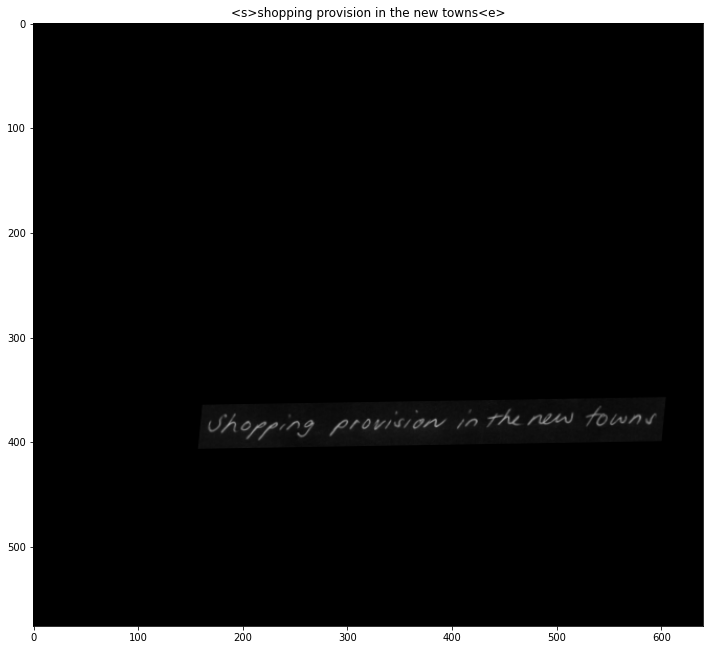

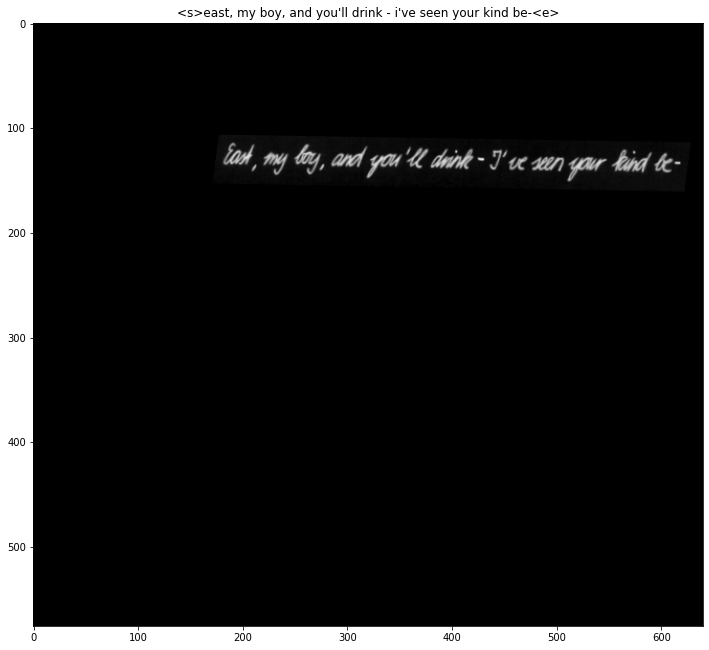

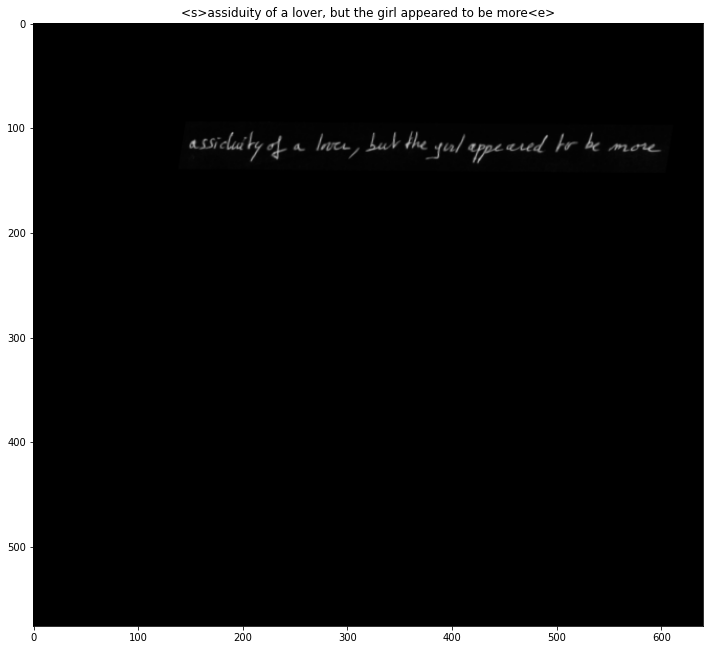

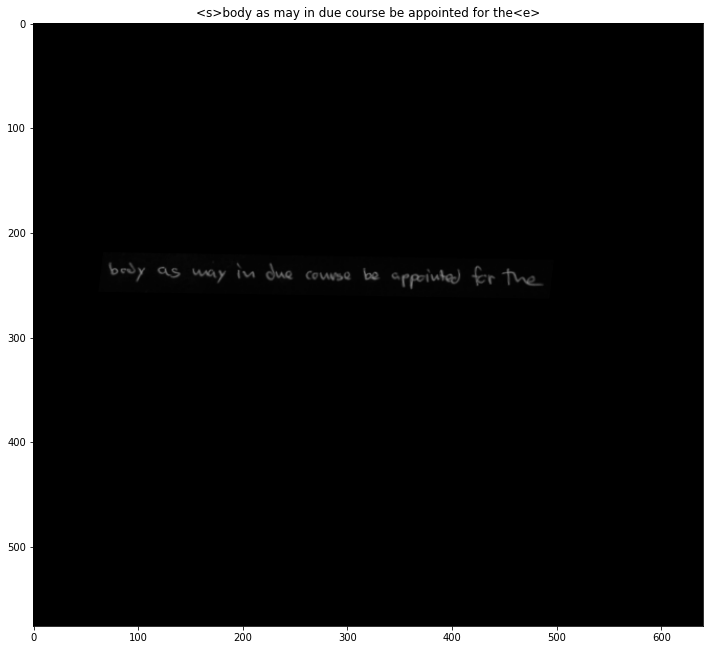

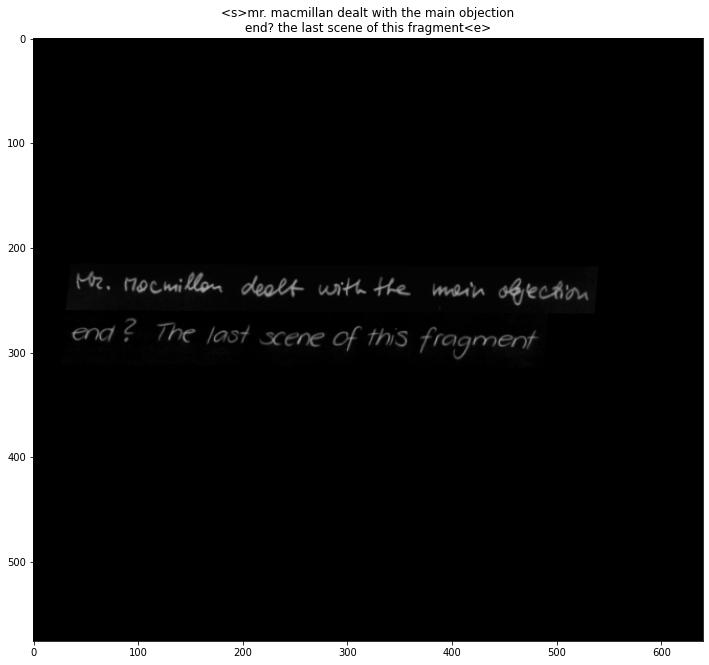

In [16]:
# Training
dataset = datamodule.data_train
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

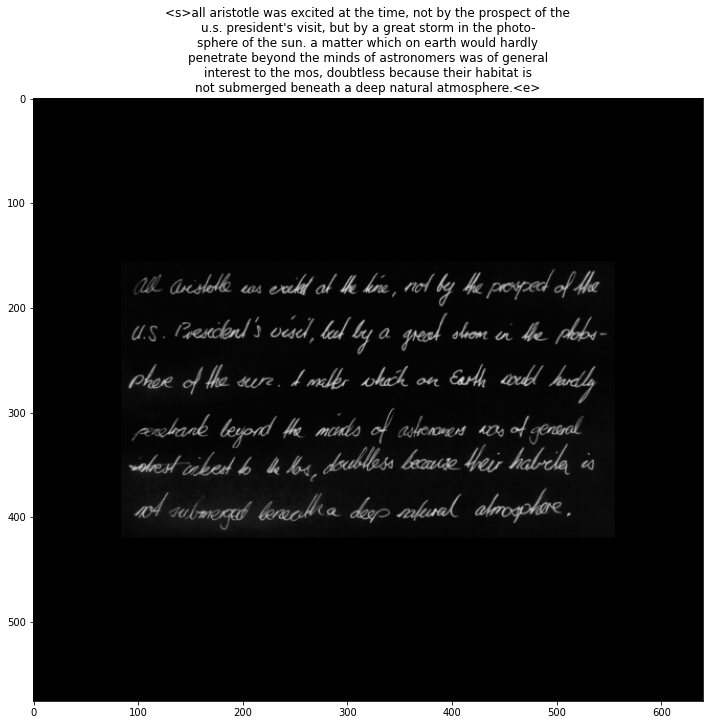

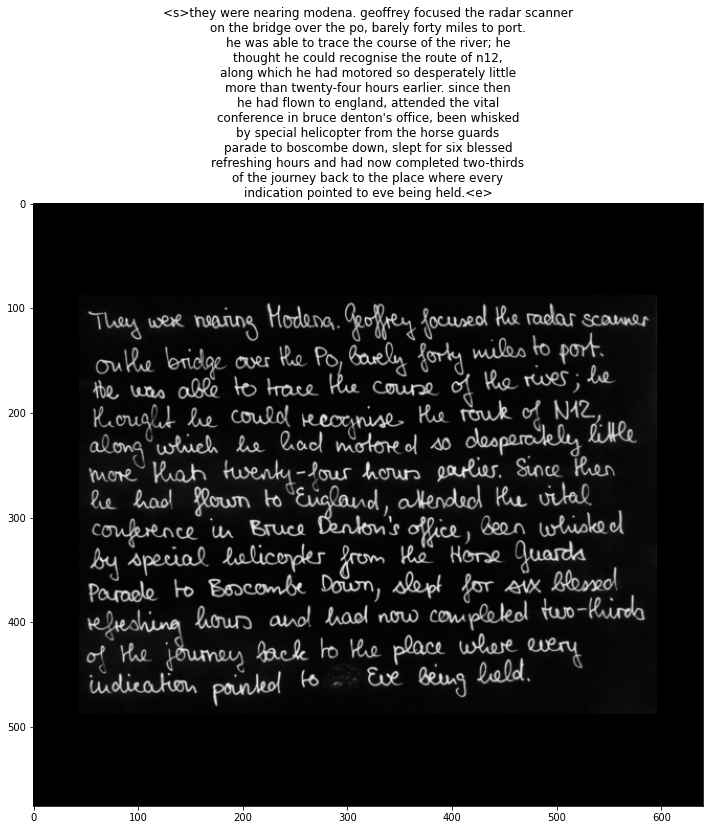

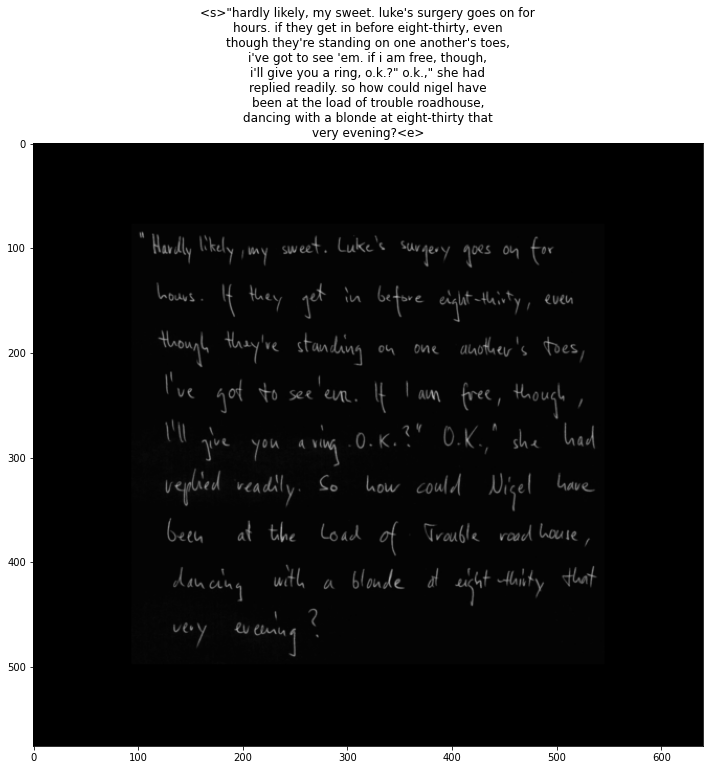

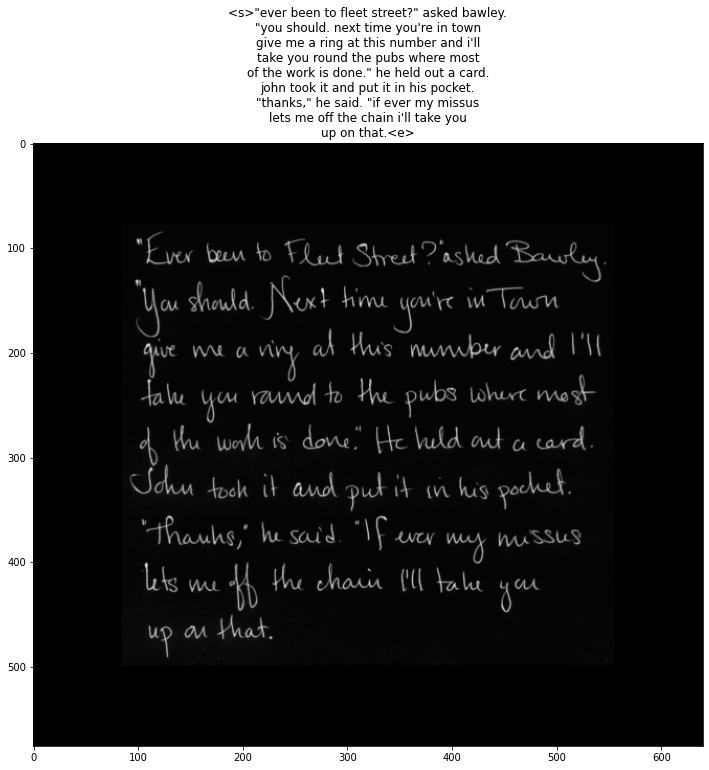

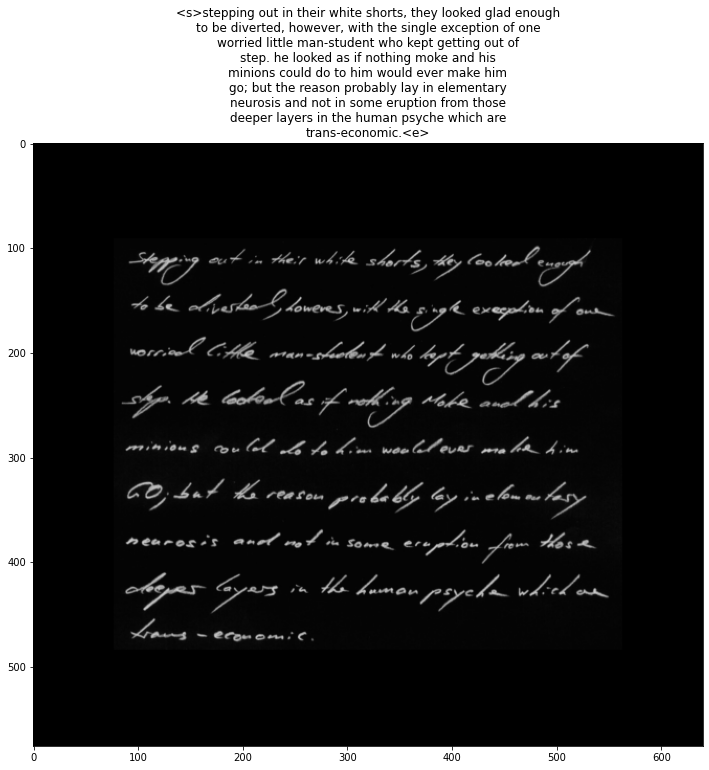

In [18]:
# Testing
dataset = datamodule.data_test
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

In [4]:
import torch

In [23]:
torch.randn(2, 256, 18, 20).flatten(start_dim=1).shape

torch.Size([2, 92160])

In [14]:
from text_recognizer.networks.barlow_twins.projector import Projector

[autoreload of text_recognizer.networks.barlow_twins.projector failed: Traceback (most recent call last):
  File "/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/aktersnurra/.cache/pypoetry/virtualenvs/text-recognizer-ejNaVa9M-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/aktersnurra/.cache/pypoetry/virtualenvs/t

In [24]:
net = Projector([92160, 4096, 256])

In [25]:
z = torch.randn(2, 256, 18, 20).flatten(start_dim=1)


In [26]:
net(z).shape

torch.Size([2, 256])